<a href="https://colab.research.google.com/github/zghayour/ML_CHW03/blob/main/ML_CHW3_Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 1

</h4>

# Personal Data

In [42]:
# Set your student number
student_number = 400101689
Name = 'Zahra'
Last_Name = 'GhayourHallaj'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch.

In [43]:
# !pip install numpy
# !pip install matplotlib
# !pip install torchvision
# !pip install torch

## Importing Libraries

In [44]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn

import numpy as np
from matplotlib import pyplot as plt
from typing import Dict

## Datasets and Dataloaders

Here, we download and load the train and test `FashionMNIST` dataset with the desired transforms. Then, we define the dataloaders for `train` and `test`.

In [45]:
train_set = FashionMNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
test_set = FashionMNIST(root='.', train=False, download=True, transform=transforms.ToTensor())


Here you have to calculate the number of classes amd input dimention of the first layer (how many pixels does each image have?).

In [46]:
## FILL HERE
print(train_set.classes)
num_classes=len(train_set.classes)
print("number of classes:",num_classes)

# Get the shape of a single image
sample_image, _ = train_set[0]
num_channels, height, width = sample_image.shape
# Calculate the total number of pixels
input_dim = num_channels * height * width
print(f"Input dimension of the first layer (pixels per image): {input_dim}")

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
number of classes: 10
Input dimension of the first layer (pixels per image): 784


In [47]:
train_loader = DataLoader(train_set, 64, shuffle=True)
test_loader = DataLoader(test_set, 64, shuffle=True)

## Visualization

Visualize 1 random image from each class by using `plt.subplots`

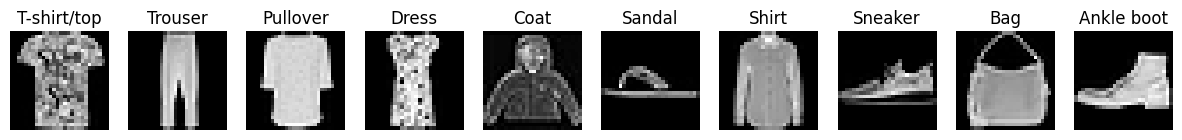

In [48]:
import random
# Create a dictionary to store class names (optional)
class_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

# Create subplots for each class
fig, axs = plt.subplots(1, 10, figsize=(15, 2))

# Randomly select one image from each class
for class_idx in range(10):
    class_samples = [i for i, (_, label) in enumerate(train_set) if label == class_idx]
    random_sample_idx = random.choice(class_samples)
    image, _ = train_set[random_sample_idx]
    image = image.squeeze().numpy()  # Remove the channel dimension

    # Display the image
    axs[class_idx].imshow(image, cmap='gray')
    axs[class_idx].set_title(class_names[class_idx])
    axs[class_idx].axis('off')  # Hide axes

plt.show()


## Initializing model's parameters

In this part, we create the model and initialize its parameters and store the values of these parameters in the variable `parameters` which is a dictionary including the weigths and biases of each layer.

In [49]:
def add_linear_layer(parameters: dict, shape, device, i=None):
    """
    This function adds parameters of a linear unit of shape `shape` to the `parameters` dictionary.
    """
    n_in, n_out = shape
    with torch.no_grad():
        w = torch.zeros(*shape, device=device)
        # kaiming initialization for ReLU activations:
        bound = 1 / np.sqrt(n_in).item()
        w.uniform_(-bound, bound)
        b = torch.zeros(n_out, device=device)  # no need to (1, n_out). it will broadcast itself.
    w.requires_grad = True
    b.requires_grad = True
    # `i` is used to give numbers to parameter names
    parameters.update({f'w{i}': w, f'b{i}': b})

Now we define our neural network with the given layers and add the weights and biases to the dictionary `parameters`. **You are allowed to modify the values of the layers**.

In [50]:
layers = [
    (input_dim, 512),
    (512, 256),
    (256, 128),
    (128, 64),
    (64, num_classes)
]
num_layers = len(layers)
parameters = {}

# setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# adding the parameters to the dictionary
for i, shape in enumerate(layers):
    add_linear_layer(parameters, shape, device, i)

parameters.keys()

dict_keys(['w0', 'b0', 'w1', 'b1', 'w2', 'b2', 'w3', 'b3', 'w4', 'b4'])

## Defining the required functions

In this section, we should define the required functions. For each of these functions, the inputs and the desired outputs are given and you should write all or part of the function. **You are not allowed to use the activation functions and the loss functions implemented in torch**.

Computing affine and relu outputs:

In [51]:
def affine_forward(x, w, b):
    """
    Computes the output of an affine transformation (linear layer).

    Args:
        x (torch.Tensor): Input tensor of shape (batch_size, input_dim).
        w (torch.Tensor): Weight tensor of shape (input_dim, output_dim).
        b (torch.Tensor): Bias tensor of shape (output_dim,).

    Returns:
        torch.Tensor: Output tensor of shape (batch_size, output_dim).
    """
    # Ensure compatible dimensions
    assert x.shape[1] == w.shape[0], "Input and weight dimensions do not match"
    assert b.shape[0] == w.shape[1], "Bias and weight dimensions do not match"

    # Compute the affine transformation
    output = torch.matmul(x, w) + b

    return output

def relu(x):
    """
    Applies the ReLU activation function element-wise to the input tensor.

    Args:
        x (torch.Tensor): Input tensor.

    Returns:
        torch.Tensor: Output tensor after applying ReLU.
    """
    return torch.max(x, torch.zeros_like(x))  # Element-wise max with zero



Function `model` returns output of the whole model for the input `x` using the parameters:

In [52]:
def model(x: torch.Tensor, parameters, num_layers=num_layers):
    """
    Computes the output of the entire neural network model for the input x using the given parameters.

    Args:
        x (torch.Tensor): Input tensor of shape (batch_size, input_dim).
        parameters (dict): Dictionary containing the weights and biases for each layer.
        num_layers (int): Number of layers in the neural network.

    Returns:
        torch.Tensor: Output tensor of shape (batch_size, num_classes).
    """
    # number of batches
    B = x.shape[0]
    x = x.view(B, -1)

    for i in range(num_layers):
        w = parameters[f'w{i}']
        b = parameters[f'b{i}']
        #print(f"Layer {i} - Input shape: {x.shape}, Weight shape: {w.shape}, Bias shape: {b.shape}")

        # Ensure compatibility of dimensions
        assert x.shape[1] == w.shape[0], f"Input and weight dimensions do not match for layer {i}"
        assert b.shape[0] == w.shape[1], f"Bias and weight dimensions do not match for layer {i}"

        x = affine_forward(x, w, b) # Matrix multiplication and bias addition
        if i < num_layers - 1:  # Apply activation function except for the last layer
            x = relu(x)

    output = x
    return output



Implementing cross entropy loss:

In [53]:
import torch

def cross_entropy_loss(scores, y):
    n = len(y)

    # Convert y to one-hot encoding if necessary
    if y.dim() == 1:
        y_one_hot = torch.zeros_like(scores)
        y_one_hot[range(n), y] = 1
    else:
        y_one_hot = y

    # Compute the logarithm of the predicted probabilities
    log_probs = torch.log(scores)

    # Compute the cross-entropy loss
    loss = -torch.sum(y_one_hot * log_probs) / n

    return loss

Implementing a function for optimizing paramters and a function to zeroing out their gradients:

In [54]:
from typing import Dict
import torch

def sgd_optimizer(parameters: Dict[str, torch.Tensor], learning_rate=0.001):
    """
    This function gets the parameters and a learning rate. Then updates the parameters using their
    gradient. Finally, you should zero the gradients of the parameters after updating
    the parameter value.

    Args:
    - parameters (Dict[str, torch.Tensor]): A dictionary where the key is the parameter name and the value is the parameter tensor.
    - learning_rate (float): The learning rate to use for the update.
    """
    for param_name, param_tensor in parameters.items():
        if param_tensor.grad is not None:
            # Update parameter using gradient descent
            param_tensor.data -= learning_rate * param_tensor.grad.data
            # Zero the gradients
            param_tensor.grad.data.zero_()

Training functions:

In [55]:
def accuracy(y_pred: np.ndarray, y_true: np.ndarray):
    correct = (y_pred == y_true).sum()
    total = len(y_true)
    acc = correct / total
    return acc

def train(train_loader, parameters, learning_rate=0.001, epoch=None):
    train_loss = 0
    N_train = len(train_loader.dataset)

    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    Y = []
    Y_pred = []

    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)

        # Calculate loss
        loss = nn.CrossEntropyLoss()(p, y)

        # Accumulate loss
        train_loss += loss.item()

        # Backpropagation
        loss.backward()
        sgd_optimizer(parameters, learning_rate)
        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())

        #print(f"Epoch [{epoch+1}], Batch [{i+1}], train_Loss: {loss.item():.4f}")

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy(Y_pred, Y)
    print(f'Accuracy of train set in Epoch [{epoch+1}]: {acc:.4f}')
    train_loss /= len(train_loader)
    return train_loss, acc


def validate(loader, epoch=None, set_name=None):
    '''This function validates the model on the test dataloader. The function goes through each batch and does
    the following on each batch:
        1- Calculate the model output
        2- Calculate the loss using the model output
        3- Print the loss for each batch and epoch

    Finally the function calculates the model accuracy.'''
    total_loss = 0
    N = len(loader.dataset)

    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    Y = []
    Y_pred = []
    for i, (x, y) in enumerate(loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)

        # Calculate loss
        loss = nn.CrossEntropyLoss()(p, y)
        total_loss += loss.item()

        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())

        #print(f"Epoch [{epoch+1}], Batch [{i+1}], {set_name}  Loss: {loss.item():.4f}")

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    total_loss /= len(loader)
    acc = accuracy(Y_pred, Y)
    print(f'Accuracy of {set_name} set in Epoch [{epoch+1}]: {acc:.4f}')

    return total_loss, acc

In [56]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [57]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def accuracy(y_pred: np.ndarray, y_true: np.ndarray):
    correct = (y_pred == y_true).sum()
    total = len(y_true)
    acc = correct / total
    return acc

def train_model(dataloaders, num_epochs, learning_rate=0.001, model_name='pytorch_model'):
    '''This function trains the model for the number of epochs given and stores, calculates and prints the train
    and test losses and accuracies. Finally, it plots the accuracy and loss history for training and test sets'''

    train_loader, test_loader = dataloaders
    for epoch in range(num_epochs):
        train_loss, train_acc = train(train_loader, parameters, learning_rate, epoch)
        test_loss, test_acc = validate(test_loader, epoch, "test")

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

    # Plot the loss history of training and test sets
    plt.figure()
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss History')
    plt.show()

    # Plot the accuracy history of training and test sets
    plt.figure()
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy History')
    plt.show()

Accuracy of train set in Epoch [1]: 0.2313
Accuracy of test set in Epoch [1]: 0.3053
Accuracy of train set in Epoch [2]: 0.3214
Accuracy of test set in Epoch [2]: 0.4385
Accuracy of train set in Epoch [3]: 0.5343
Accuracy of test set in Epoch [3]: 0.5891
Accuracy of train set in Epoch [4]: 0.6369
Accuracy of test set in Epoch [4]: 0.6712
Accuracy of train set in Epoch [5]: 0.6914
Accuracy of test set in Epoch [5]: 0.7197
Accuracy of train set in Epoch [6]: 0.7344
Accuracy of test set in Epoch [6]: 0.7443
Accuracy of train set in Epoch [7]: 0.7638
Accuracy of test set in Epoch [7]: 0.7434
Accuracy of train set in Epoch [8]: 0.7794
Accuracy of test set in Epoch [8]: 0.7729
Accuracy of train set in Epoch [9]: 0.7901
Accuracy of test set in Epoch [9]: 0.7878
Accuracy of train set in Epoch [10]: 0.7990
Accuracy of test set in Epoch [10]: 0.7835
Accuracy of train set in Epoch [11]: 0.8066
Accuracy of test set in Epoch [11]: 0.8028
Accuracy of train set in Epoch [12]: 0.8131
Accuracy of test 

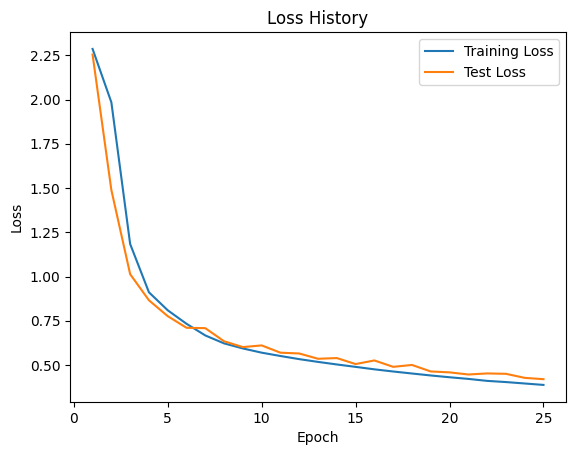

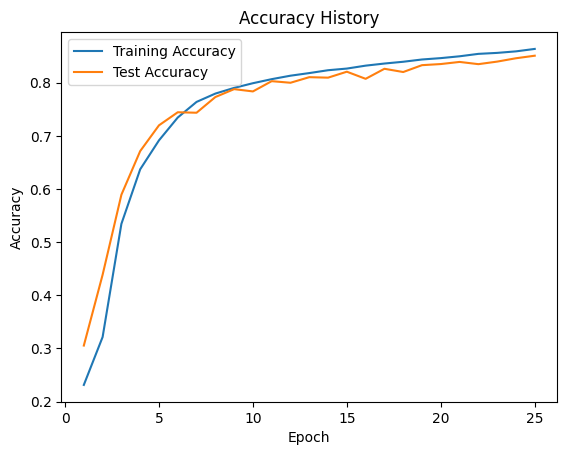

In [58]:
train_model([train_loader, test_loader], num_epochs=25, learning_rate=0.005)

In [59]:
print(f'Final test accuracy: {test_accuracies[-1]}')

Final test accuracy: 0.8507


## Visualization of the labels and predictions

In this section, you should visual one image from each class and show both the actual label and the predicted label for that image.

In [64]:
def retrieve_one_image_per_class(loader, model):
    image_dict = {}
    label_dict = {}

    with torch.no_grad():
        for data, labels in loader:
            data = data.to(device)
            labels = labels.to(device)
            outputs = model(data, parameters)
            _, predictions = torch.max(outputs, 1)

            for i in range(len(labels)):
                label = labels[i].item()

                if label not in image_dict:
                    image_dict[label] = data[i].cpu()
                    label_dict[label] = (labels[i].item(), predictions[i].item())

                if len(image_dict) >= 10:
                    return image_dict, label_dict

    return image_dict, label_dict

def visualize_images(image_dict, label_dict, class_names):
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    axes = axes.flatten()

    for i, (label, image) in enumerate(image_dict.items()):
        ax = axes[i]
        ax.imshow(image.squeeze(), cmap='gray')
        actual_label, predicted_label = label_dict[label]
        ax.set_title(f'Actual: {class_names[actual_label]}\nPredicted: {class_names[predicted_label]}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

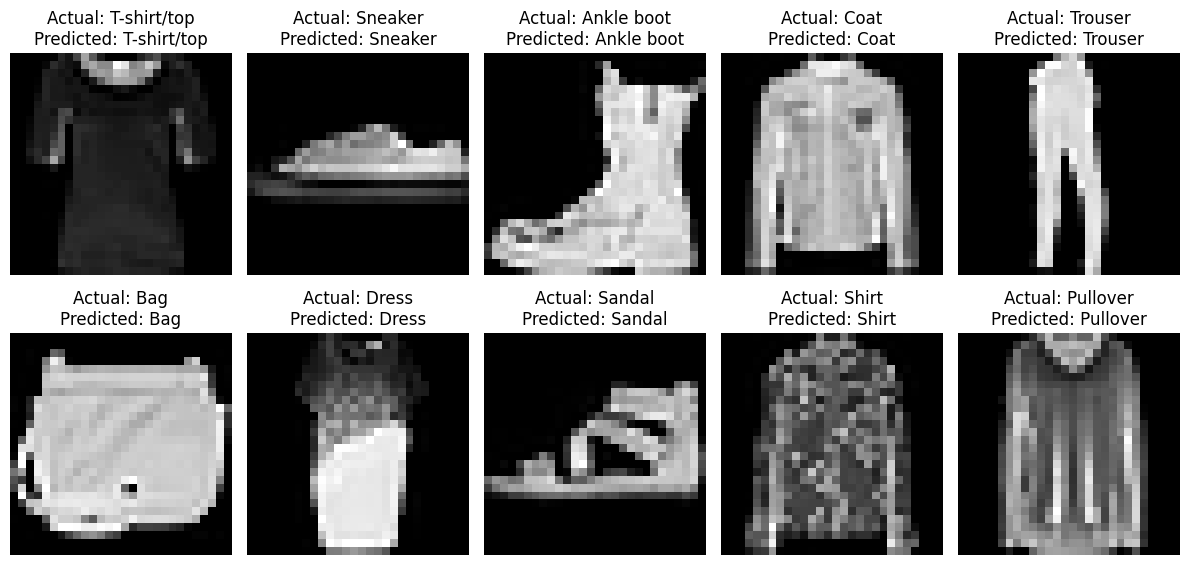

In [66]:
    image_dict, label_dict = retrieve_one_image_per_class(test_loader, model)
    class_names = test_loader.dataset.classes
    visualize_images(image_dict, label_dict, class_names)